# Regression task

# Preparation 

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch211217/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch211217/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [ ]:
! pip install lark-parser

In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [ ]:
import sys
sys.path.append("../")
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

## サンプルデータの生成

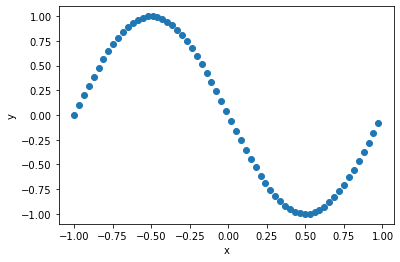

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(1)

input_data   = np.arange( 0, np.pi*2.0, 0.1 )
correct_data = np.sin( input_data )
n_data = len( correct_data )

# 入力を[-1.0,1.0]の範囲に
input_data = ( input_data - np.pi )/ np.pi

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter( input_data, correct_data)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

## ニューラルネットワークの定義

In [ ]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

class MSE(torch.nn.Module):
  
  class Net( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create net class")
      self.fc1 = torch.nn.Linear(1,32)
      self.fc2 = torch.nn.Linear(32,16)
      self.fc3 = torch.nn.Linear(16,1)

    def forward(self,x):
      y = torch.nn.functional.relu(self.fc1(x))
      y = torch.nn.functional.relu(self.fc2(y))
      y = self.fc3(y)
      return y

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      #output = mean_squared_error( x, t )
      loss = nn.MSELoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( MSE, self ).__init__()
    print("create mse class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    output = self.loss( self.out, self.target )
    return output

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [ ]:
project = 'regr'
folder = "./regression"
json_path = folder +'/' + project +'.json'

In [ ]:
! mkdir -p regression

計算グラフをJSONファイルに出力する

In [ ]:
def generate_json( json_path, input, target ):
    model = MSE( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [ ]:
torch.manual_seed( 1 )

input_data   = input_data.reshape(-1,1)
correct_data = correct_data.reshape(-1,1)
x_tensor = torch.from_numpy(input_data).float()
y_tensor = torch.from_numpy(correct_data).float()

batchs = 63
xb = x_tensor[0:batchs,:]
yb = y_tensor[0:batchs,:]

xb.requires_grad = True
model = generate_json( json_path, xb, yb )

create mse class
create net class
create loss class
[SAVE] ./regression/regr.json
skip: MSE/Net[net]/Linear[fc1]/weight/fc1
skip: MSE/Net[net]/Linear[fc1]/weight/fc1
skip: MSE/Net[net]/Linear[fc2]/weight/fc2
skip: MSE/Net[net]/Linear[fc2]/weight/fc2
skip: MSE/Net[net]/Linear[fc3]/weight/fc3
skip: MSE/Net[net]/Linear[fc3]/weight/fc3


C++コードを生成する

In [ ]:
minictorch.convert_all( project, folder, model, json_path, xb, {"input_data":input_data, "target_data":correct_data}, code="all", sol="regr", epochs=2000, batch=9 )

[JSON] ./regression/regr.json
{'name': 'MSE/Net[net]/Linear[fc1]/weight/weight.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'MSE/Net[net]/Linear[fc1]/bias/bias.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'MSE/Net[net]/Linear[fc2]/weight/weight.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'MSE/Net[net]/Linear[fc2]/bias/bias.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'MSE/Net[net]/Linear[fc3]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 9}
{'name': 'MSE/Net[net]/Linear[fc3]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 10}
[PARAM] ./regression/regr_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [63, 1], 'out': [

In [ ]:
# check code
with torch.set_grad_enabled(True):
  model.train()
  yy = model( xb )
  print("output",yy)
  print("out",model.out.shape)
  yy.backward()
  #print("input",xb.grad)

output tensor(0.5289, grad_fn=<MseLossBackward0>)
out torch.Size([63, 1])


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [4]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

Cloning into 'xtensor'...
remote: Enumerating objects: 20418, done.
remote: Counting objects: 100% (3167/3167), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 20418 (delta 2722), reused 2919 (delta 2637), pack-reused 17251
Receiving objects: 100% (20418/20418), 10.07 MiB | 3.59 MiB/s, done.
Resolving deltas: 100% (14570/14570), done.
Checking out files: 100% (385/385), done.
Cloning into 'xtensor-blas'...
remote: Enumerating objects: 3857, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 3857 (delta 83), reused 96 (delta 41), pack-reused 3688
Receiving objects: 100% (3857/3857), 4.13 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (3155/3155), done.
Checking out files: 100% (1435/1435), done.
Cloning into 'xtl'...
remote: Enumerating objects: 2399, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 2399 (delta 125), reused 137 

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

Cloning into 'MiniCTorch_Prototype'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (728/728), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 728 (delta 499), reused 583 (delta 367), pack-reused 0
Receiving objects: 100% (728/728), 42.78 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (499/499), done.


# コンパイル

In [ ]:
C_SRC = './regression/regr.cpp ./regression/regr_param.cpp'
C_OPT = '-I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './regression/regr'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./regression/regr.cpp ./regression/regr_param.cpp
OPT = -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./regression/regr


In [ ]:
!./regression/regr

### forward computation ...
 0.528857
### backward computation ...
input_grad{{ 0.000114},
 { 0.00021 },
 { 0.000305},
 {-0.000047},
 {-0.000057},
 {-0.000067},
 {-0.000077},
 {-0.000086},
 {-0.000094},
 {-0.000101},
 {-0.000108},
 {-0.000731},
 {-0.00076 },
 {-0.000783},
 { 0.000304},
 { 0.000307},
 { 0.000308},
 { 0.000336},
 { 0.000331},
 {-0.000714},
 {-0.000689},
 {-0.000657},
 {-0.001141},
 {-0.001062},
 {-0.000946},
 {-0.000853},
 {-0.000752},
 {-0.00026 },
 {-0.000441},
 {-0.000346},
 {-0.000248},
 {-0.000148},
 {-0.000049},
 { 0.00005 },
 { 0.000148},
 { 0.000243},
 { 0.000335},
 { 0.000422},
 { 0.000504},
 { 0.00058 },
 { 0.000649},
 { 0.00114 },
 { 0.001227},
 { 0.0013  },
 { 0.001245},
 { 0.001285},
 { 0.00131 },
 { 0.001321},
 { 0.001318},
 { 0.0013  },
 { 0.001268},
 { 0.001222},
 { 0.001163},
 { 0.001091},
 { 0.001007},
 { 0.000451},
 { 0.000398},
 { 0.000341},
 { 0.000279},
 { 0.000215},
 { 0.000147},
 {-0.000025},
 {-0.000002}}


# Python 学習コード

学習ループの実行(python版)

In [ ]:
torch.manual_seed( 1 )

epochs = 2000

model = MSE( y_tensor )
model.train()

lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr)
#opt = torch.optim.Adam(net.parameters(), lr )

x_tensor.requires_grad = True

batch_size = 9
n_batch = len(x_tensor) // batch_size  # 1エポックあたりのバッチ数
print("batch ",n_batch,batch_size)

epoch_loss = []
for i in range(epochs):

    # -- 学習 -- 
    """
    opt.zero_grad()
    loss = net( x_tensor )
    total_loss = loss;
    loss.backward()
    opt.step()
    """
    # ミニバッチ
    index_random = np.arange( n_data )
    np.random.shuffle( index_random )  # インデックスをシャッフルする

    total_loss = 0.0
    for idx in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ idx*batch_size : (idx+1)*batch_size ]
        x = x_tensor[ mb_index,:]
        t = y_tensor[ mb_index,:]
        
        # 順伝播と逆伝播
        model.target = t
        loss = model( x )
        total_loss += loss;
        #print("loss",loss)

        opt.zero_grad()
        loss.backward()
        opt.step()
    #"""
    # -- 誤差 --
    print("epoch: {} loss: {}".format(i, total_loss))
    epoch_loss.append( total_loss )

#model.target = y_tensor
#output = model.net( x_tensor )

create mse class
create net class
create loss class
batch  7 9
epoch: 0 loss: 3.6137804985046387
epoch: 1 loss: 3.3821678161621094
epoch: 2 loss: 3.202080726623535
epoch: 3 loss: 3.0389389991760254
epoch: 4 loss: 2.892347574234009
epoch: 5 loss: 2.7466061115264893
epoch: 6 loss: 2.607574224472046
epoch: 7 loss: 2.4707016944885254
epoch: 8 loss: 2.366652250289917
epoch: 9 loss: 2.2197823524475098
epoch: 10 loss: 2.106710910797119
epoch: 11 loss: 2.001077175140381
epoch: 12 loss: 1.898061752319336
epoch: 13 loss: 1.8142292499542236
epoch: 14 loss: 1.712435007095337
epoch: 15 loss: 1.6313889026641846
epoch: 16 loss: 1.5574402809143066
epoch: 17 loss: 1.4987295866012573
epoch: 18 loss: 1.4270442724227905
epoch: 19 loss: 1.3785794973373413
epoch: 20 loss: 1.3321971893310547
epoch: 21 loss: 1.2915775775909424
epoch: 22 loss: 1.2500700950622559
epoch: 23 loss: 1.2205064296722412
epoch: 24 loss: 1.2030971050262451
epoch: 25 loss: 1.173769235610962
epoch: 26 loss: 1.153060793876648
epoch: 27 lo

In [ ]:
model.target = y_tensor
output = model.net( x_tensor )
print( x_tensor )

tensor([[-1.0000],
        [-0.9682],
        [-0.9363],
        [-0.9045],
        [-0.8727],
        [-0.8408],
        [-0.8090],
        [-0.7772],
        [-0.7454],
        [-0.7135],
        [-0.6817],
        [-0.6499],
        [-0.6180],
        [-0.5862],
        [-0.5544],
        [-0.5225],
        [-0.4907],
        [-0.4589],
        [-0.4270],
        [-0.3952],
        [-0.3634],
        [-0.3315],
        [-0.2997],
        [-0.2679],
        [-0.2361],
        [-0.2042],
        [-0.1724],
        [-0.1406],
        [-0.1087],
        [-0.0769],
        [-0.0451],
        [-0.0132],
        [ 0.0186],
        [ 0.0504],
        [ 0.0823],
        [ 0.1141],
        [ 0.1459],
        [ 0.1777],
        [ 0.2096],
        [ 0.2414],
        [ 0.2732],
        [ 0.3051],
        [ 0.3369],
        [ 0.3687],
        [ 0.4006],
        [ 0.4324],
        [ 0.4642],
        [ 0.4961],
        [ 0.5279],
        [ 0.5597],
        [ 0.5915],
        [ 0.6234],
        [ 0.

収束状況グラフを描画する

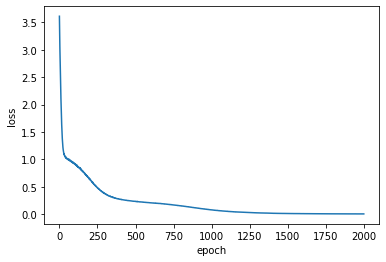

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

(63, 1)


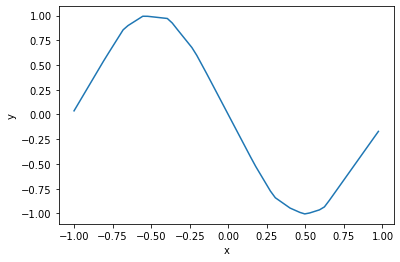

In [ ]:
o = output.to('cpu').detach().numpy().copy()
print(o.shape)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(input_data, o)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [ ]:
C_SRC = './regression/regr_train.cpp ./regression/regr_param.cpp ./regression/regr.cpp ./regression/regr_data.cpp'
C_OPT = '-I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './regression/regr_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./regression/regr_train.cpp ./regression/regr_param.cpp ./regression/regr.cpp ./regression/regr_data.cpp
OPT = -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./regression/regr_train


In [ ]:
!./regression/regr_train

epoch_num : 2000
batch  number  : 7,9
learning ratio : 0.01
total_loss : epoch 0 - loss 3.6291
epoch 0 - loss 0.494218
total_loss : epoch 1 - loss 3.37867
epoch 1 - loss 0.465534
total_loss : epoch 2 - loss 3.20884
epoch 2 - loss 0.441772
total_loss : epoch 3 - loss 3.03129
epoch 3 - loss 0.419926
total_loss : epoch 4 - loss 2.89771
epoch 4 - loss 0.398791
total_loss : epoch 5 - loss 2.7474
epoch 5 - loss 0.378773
total_loss : epoch 6 - loss 2.59818
epoch 6 - loss 0.359284
total_loss : epoch 7 - loss 2.47471
epoch 7 - loss 0.340885
total_loss : epoch 8 - loss 2.34494
epoch 8 - loss 0.323585
total_loss : epoch 9 - loss 2.23556
epoch 9 - loss 0.306924
total_loss : epoch 10 - loss 2.11225
epoch 10 - loss 0.290817
total_loss : epoch 11 - loss 1.99432
epoch 11 - loss 0.275707
total_loss : epoch 12 - loss 1.89782
epoch 12 - loss 0.261583
total_loss : epoch 13 - loss 1.79782
epoch 13 - loss 0.248281
total_loss : epoch 14 - loss 1.73392
epoch 14 - loss 0.236211
total_loss : epoch 15 - loss 1.6

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []

datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

path = folder + '/' + project + '.pred'
f2 = open( path, 'r')

x_new = []
y_pred = []
k = 0
datalist = f2.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  if k == 0:
    print(ds)
    n1 = int(ds[0])
    n2 = int(ds[1])
  else:
    x_new.append( input_data[k-1,0] )
    y_pred.append( float(ds[0]) )
  k = k+1

f2.close()

print("pred =", len(x_new))
print( x_new )
print( y_pred )


epoch = 2000
[0.494218, 0.465534, 0.441772, 0.419926, 0.398791, 0.378773, 0.359284, 0.340885, 0.323585, 0.306924, 0.290817, 0.275707, 0.261583, 0.248281, 0.236211, 0.224994, 0.21507, 0.206208, 0.198375, 0.191401, 0.185117, 0.179774, 0.175224, 0.171052, 0.1676, 0.164671, 0.161918, 0.159665, 0.157721, 0.156139, 0.154487, 0.15314, 0.151929, 0.150911, 0.150055, 0.149196, 0.148495, 0.147906, 0.147248, 0.146743, 0.14627, 0.14583, 0.145465, 0.145138, 0.144711, 0.144369, 0.143945, 0.143659, 0.143319, 0.143016, 0.142711, 0.142436, 0.142152, 0.14185, 0.141572, 0.141389, 0.141229, 0.140784, 0.140527, 0.140279, 0.14, 0.13974, 0.139482, 0.139215, 0.138953, 0.138692, 0.13844, 0.138382, 0.138108, 0.137663, 0.137521, 0.137161, 0.137021, 0.136627, 0.136358, 0.13622, 0.135855, 0.135578, 0.135354, 0.135048, 0.134798, 0.134555, 0.134226, 0.133953, 0.133675, 0.133397, 0.133123, 0.132846, 0.132581, 0.132335, 0.131983, 0.131687, 0.131501, 0.131128, 0.130894, 0.130605, 0.130247, 0.129941, 0.129637, 0.129332, 

収束状況グラフを描画する

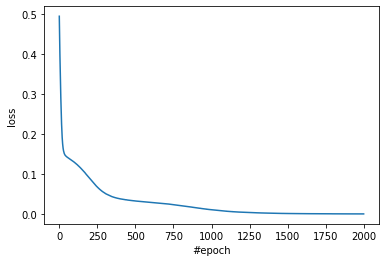

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

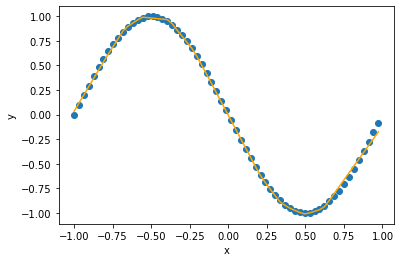

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(input_data,correct_data )
ax.plot( x_new, y_pred, c='orange')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()